In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torchvision import models
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [15]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}')

print('Finished Training')

Epoch [1/15], Loss: 0.8312
Epoch [2/15], Loss: 0.9120
Epoch [3/15], Loss: 0.7170
Epoch [4/15], Loss: 0.5610
Epoch [5/15], Loss: 0.4684
Epoch [6/15], Loss: 0.3825
Epoch [7/15], Loss: 0.3180
Epoch [8/15], Loss: 0.2575
Epoch [9/15], Loss: 0.3781
Epoch [10/15], Loss: 0.2326
Epoch [11/15], Loss: 0.1493
Epoch [12/15], Loss: 0.1299
Epoch [13/15], Loss: 0.1253
Epoch [14/15], Loss: 0.1111
Epoch [15/15], Loss: 0.0968
Finished Training


In [22]:
import numpy as np
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [23]:
data_iter = iter(testloader)
images, labels = next(data_iter)
images, labels = images[0].unsqueeze(0).to(device), labels[0].item()

In [24]:
target_layers = [model.layer4[-1]]
targets = [ClassifierOutputTarget(labels)]

In [32]:
data_iter = iter(testloader)
images, labels = next(data_iter)
image, label = images[0].unsqueeze(0).to(device), labels[0].item()

target_layers = [model.layer4[-1]]
targets = [ClassifierOutputTarget(label)]

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=image, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    rgb_img = image.squeeze().cpu().numpy().transpose(1, 2, 0)
    rgb_img = (rgb_img * 0.5 + 0.5)
    rgb_img = np.clip(rgb_img, 0, 1)
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Image.fromarray((visualization * 255).astype(np.uint8)).show()

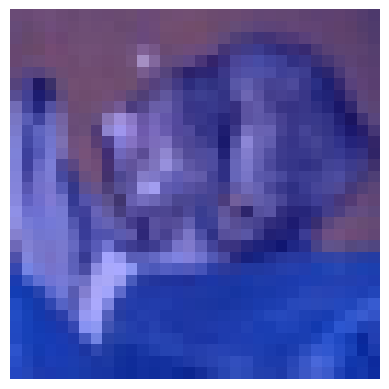

In [34]:
data_iter = iter(testloader)
images, labels = next(data_iter)
image, label = images[0].unsqueeze(0).to(device), labels[0].item()

# Initialize Grad-CAM
target_layers = [model.layer4[-1]]  # Use the last layer of ResNet
targets = [ClassifierOutputTarget(label)]

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=image, targets=targets)
    grayscale_cam = grayscale_cam[0, :]  # Get the CAM for the first image in the batch

    # Convert the input image to a numpy array for visualization
    rgb_img = image.squeeze().cpu().numpy().transpose(1, 2, 0)
    rgb_img = (rgb_img * 0.5 + 0.5)  # Denormalize to [0, 1]
    rgb_img = np.clip(rgb_img, 0, 1)  # Ensure values are between 0 and 1

    # Visualize the CAM on the image
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Display the visualization using matplotlib
plt.imshow(visualization)
plt.axis('off')  # Hide axes
plt.show()